# **Flare Prediction using Neural ODE**

여기서부터 프로젝트 시작

In [ ]:
!pip install --upgrade sympy
!pip install zarr sunpy[all] s3fs
!pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 56.1 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu121 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.8/959.8 kB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92

In [ ]:
%matplotlib inline

import os
from typing import Union
import zarr

import gcsfs
import s3fs
import sunpy.map

import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import sunpy.visualization.colormaps as cm

from astropy.time import Time
from sunpy.visualization import axis_labels_from_ctype, wcsaxes_compat

from matplotlib import animation
from IPython.display import HTML

In [ ]:
AWS_ZARR_ROOT = (
    "s3://gov-nasa-hdrl-data1/contrib/fdl-sdoml/fdl-sdoml-v2/sdomlv2_small.zarr/"
)


def s3_connection(path_to_zarr: os.path) -> s3fs.S3Map:
    """
    Instantiate connection to aws for a given path `path_to_zarr`
    """
    return s3fs.S3Map(
        root=path_to_zarr,
        s3=s3fs.S3FileSystem(anon=True),
        # anonymous access requires no credentials
        check=False,
    )


def load_single_aws_zarr(
    path_to_zarr: os.path,
    cache_max_single_size: int = None,
) -> Union[zarr.Array, zarr.Group]:
    """
    load zarr from s3 using LRU cache
    """
    return zarr.open(
        zarr.LRUStoreCache(
            store=s3_connection(path_to_zarr),
            max_size=cache_max_single_size,
        ),
        mode="r",
    )

In [ ]:
root = load_single_aws_zarr(
    path_to_zarr="s3://gov-nasa-hdrl-data1/contrib/fdl-sdoml/fdl-sdoml-v2/sdomlv2_hmi_small.zarr/",
)

data_Bx = root["2010"]["Bx"]
data_By = root["2010"]["By"]
data_Bz = root["2010"]["Bz"]

t_obs = np.array(data_Bz.attrs["T_OBS"])

t_obs_new = []
for string in t_obs:
    new_string = string.replace('_TAI', 'Z')
    new_string = new_string.replace('_','T')
    new_string = new_string.replace('.','-')
    new_string = new_string.replace('Z', '.00')
    t_obs_new.append(new_string)
t = Time(t_obs_new, format='isot', scale='tai')
t_obs_new=t.value

da.from_array(data_Bz)[0, :, :]
selected_header = {keys: values[100:200] for keys, values in data_Bz.attrs.items()}
selected_header

selected_image = da.from_array(data_Bz)[0, :, :]
selected_headr = {keys: values[0] for keys, values in data_Bz.attrs.items()}
selected_headr['WAVEUNIT'] = 'angstrom'
my_map = sunpy.map.Map((np.array(selected_image), selected_headr))
my_map

df_time = pd.DataFrame(t_obs_new, index=np.arange(np.shape(t_obs_new)[0]), columns=["Time"])
df_time["Time"] = pd.to_datetime(df_time["Time"])

# select times at a frequency of 12 minutes
selected_times = pd.date_range(
    start="2010-08-28 00:00:00", end="2010-08-28 23:59:59", freq="12T")

selected_index = []
for i in selected_times:
    selected_index.append(np.argmin(abs(df_time["Time"] - i)))

#mark the missing timestamps in the data
missing_index=np.where(abs(df_time['Time'][selected_index]-selected_times)>pd.Timedelta('3m'))[0].tolist()
for i in missing_index:
    selected_index[i]=-1

# may be a more efficient way of doing this
time_index = list(filter(lambda x: x > 0, selected_index))
da.from_array(data_Bz)[time_index, :, :]

/usr/local/lib/python3.10/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 291 of "time is after end of day (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
<ipython-input-8-7971be2793d6>:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  selected_times = pd.date_range(


dask.array<getitem, shape=(110, 512, 512), dtype=float32, chunksize=(110, 512, 512), chunktype=numpy.ndarray>

In [ ]:
data_Bx.shape

(25540, 512, 512)

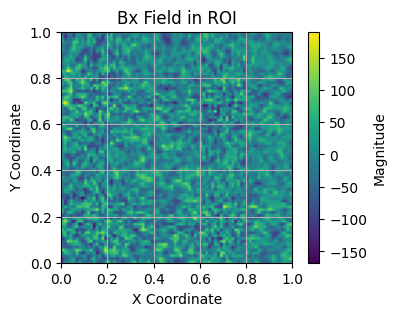

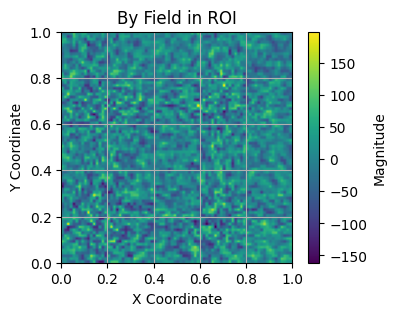

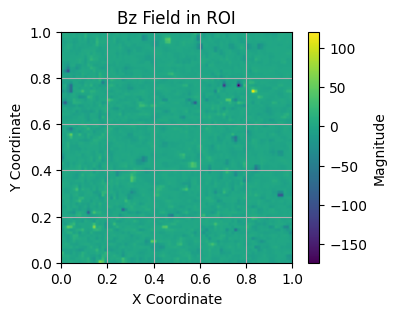

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 준비 (Bx, By, Bz)
grid_size = 30  # 데이터 격자 크기
x = np.linspace(0, 1, grid_size)
y = np.linspace(0, 1, grid_size)
z = np.linspace(0, 1, grid_size)
x, y, z = np.meshgrid(x, y, z)

# 특정 시간(time_index)의 데이터 추출
time_index = 3  # 사용할 시간 인덱스
Bx = data_Bx[time_index, :, :]  # X 방향 자기장
By = data_By[time_index, :, :]  # Y 방향 자기장
Bz = data_Bz[time_index, :, :]  # Z 방향 자기장

# ROI 설정
roi_x_start, roi_x_end = 160, 240  # x축의 ROI 범위
roi_y_start, roi_y_end = 160, 240  # y축의 ROI 범위

# ROI 데이터 슬라이싱 (2D 데이터)
Bx_roi = Bx[roi_x_start:roi_x_end, roi_y_start:roi_y_end]
By_roi = By[roi_x_start:roi_x_end, roi_y_start:roi_y_end]
Bz_roi = Bz[roi_x_start:roi_x_end, roi_y_start:roi_y_end]

# 2D 시각화 함수
def plot_2d_field(data, title, cmap="viridis"):
    plt.figure(figsize=(4, 3))
    plt.imshow(data, cmap=cmap, origin="lower", extent=(0, 1, 0, 1))
    plt.colorbar(label="Magnitude")
    plt.title(title)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)
    plt.show()

# ROI 데이터를 시각화
plot_2d_field(Bx_roi, title="Bx Field in ROI")
plot_2d_field(By_roi, title="By Field in ROI")
plot_2d_field(Bz_roi, title="Bz Field in ROI")

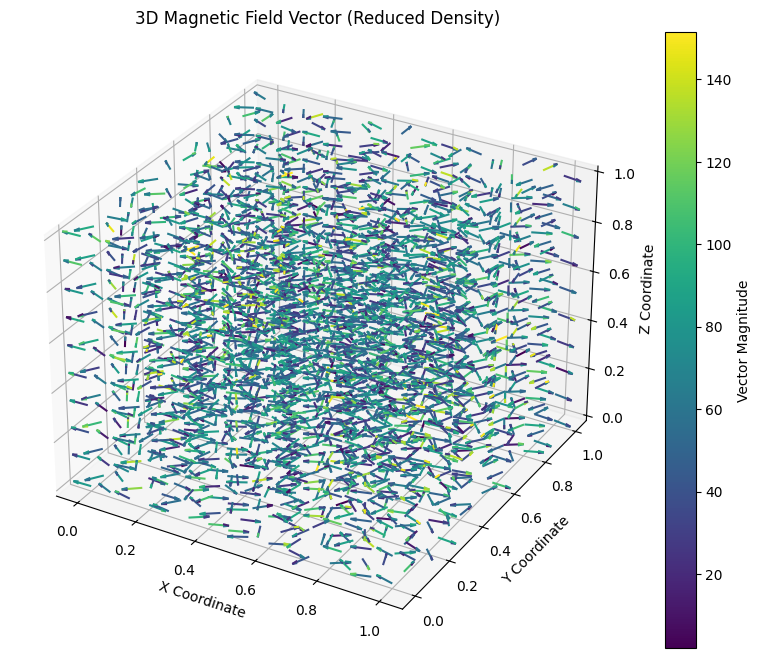

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 샘플링 간격 설정
sampling_step = 5 # 밀도를 줄이기 위한 샘플링 간격

# ROI 크기 계산
roi_size_x = (roi_x_end - roi_x_start) // sampling_step  # x축 크기
roi_size_y = (roi_y_end - roi_y_start) // sampling_step  # y축 크기
roi_size_z = 10  # z축 샘플링 크기

# 샘플링한 좌표 생성
x = np.linspace(0, 1, roi_size_x)
y = np.linspace(0, 1, roi_size_y)
z = np.linspace(0, 1, roi_size_z)
x, y, z = np.meshgrid(x, y, z)

# ROI 데이터 샘플링 (간격을 두고 데이터 선택)
Bx_sampled = Bx_roi[::sampling_step, ::sampling_step][:, :, np.newaxis]
By_sampled = By_roi[::sampling_step, ::sampling_step][:, :, np.newaxis]
Bz_sampled = np.zeros_like(Bx_sampled)  # Z 방향은 0으로 초기화

# 벡터 크기 계산
magnitude = np.sqrt(Bx_sampled**2 + By_sampled**2 + Bz_sampled**2)

# 3D 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# 벡터 크기를 색상으로 매핑
norm = plt.Normalize(vmin=magnitude.min(), vmax=magnitude.max())
colors = plt.cm.viridis(norm(magnitude))

# 3D quiver 플롯
quiver = ax.quiver(
    x, y, z,  # 좌표
    Bx_sampled, By_sampled, Bz_sampled,  # 벡터 성분
    color=colors.reshape(-1, 4),  # 색상 매핑 (RGBA 형태)
    length=0.06,  # 화살표 길이
    normalize=True
)

# 컬러바 추가
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Vector Magnitude")

# 축 설정
ax.set_title("3D Magnetic Field Vector (Reduced Density)")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")

plt.show()

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class MagneticFieldDataset(Dataset):
  def __init__(self, data_Bx, data_By, data_Bz, time_indices, roi_bounds, sampling_step):
    self.data_Bx = data_Bx
    self.data_By = data_By
    self.data_Bz = data_Bz
    self.time_indices = time_indices
    self.roi_bounds = roi_bounds
    self.sampling_step = sampling_step

    #ROI 범위 정의
    self.x_start, self.x_end = roi_bounds[0]
    self.y_start, self.y_end = roi_bounds[1]
    # self.z_start, self.z_end = roi_bounds[2]

  def __len__(self):
    return len(self.time_indices)-1

  def __getitem__(self, idx):
    start_idx = self.time_indices[idx]
    end_idx = self.time_indices[idx+1]

    # ROI slicing
    Bx = self.data_Bx[start_idx:end_idx, self.x_start:self.x_end, self.y_start:self.y_end] # self.z_start:self.z_end]
    By = self.data_By[start_idx:end_idx, self.x_start:self.x_end, self.y_start:self.y_end] # self.z_start:self.z_end]
    Bz = self.data_Bz[start_idx:end_idx, self.x_start:self.x_end, self.y_start:self.y_end] # self.z_start:self.z_end]

    # sampling
    Bx = Bx[:, ::self.sampling_step, ::self.sampling_step] # ::self.sampling_step]
    By = By[:, ::self.sampling_step, ::self.sampling_step] # ::self.sampling_step]
    Bz = Bz[:, ::self.sampling_step, ::self.sampling_step] # ::self.sampling_step]

    vector_field = np.stack([Bx, By, Bz], axis = 0)

    return torch.tensor(vector_field, dtype = torch.float32)

# ROI setting / data prepairing
roi_bounds = ((160, 170), (160, 170))
sampling_step = 1
time_indices = list(range(1000)) # data_Bx.shape[0] : 전체 시간

data_Bx = root["2010"]["Bx"]
data_By = root["2010"]["By"]
data_Bz = root["2010"]["Bz"]

dataset = MagneticFieldDataset(data_Bx, data_By, data_Bz, time_indices, roi_bounds, sampling_step)

train_size = int(0.7*len(dataset))
val_size = int(0.15*len(dataset))
test_size = len(dataset) - train_size - val_size
print('train_size : ', train_size, '\n val_size : ', val_size, '\n test_size : ', test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 8, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 8, shuffle = False)

train_size :  699 
 val_size :  149 
 test_size :  151


In [ ]:
print(data_Bx.shape)

(25540, 512, 512)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# **New Version**

Using device: cuda
Preparing data...
Loading HMI data...


/usr/local/lib/python3.10/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 291 of "time is after end of day (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
<ipython-input-5-0cb387575b0c>:92: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  selected_times = pd.date_range(


befor slicing time indices : 220
time indices : [12889, 12889, 12890, 12890, 12891, 12891, 12892, 12892, 12893, 12893, 12894, 12894, 12895, 12895, 12896, 12896, 12897, 12897, 12898, 12898, 12899, 12899, 12900, 12900, 12901, 12901, 12902, 12902, 12903, 12903, 12904, 12904, 12905, 12905, 12906, 12906, 12907, 12907, 12908, 12908, 12909, 12909, 12910, 12910, 12911, 12911, 12912, 12912, 12913, 12913, 12914, 12914, 12915, 12915, 12916, 12916, 12917, 12917, 12918, 12918, 12919, 12919, 12920, 12920, 12921, 12921, 12922, 12922, 12923, 12923, 12924, 12924, 12925, 12925, 12926, 12926, 12927, 12927, 12928, 12928, 12929, 12929, 12930, 12930, 12931, 12931, 12932, 12932, 12933, 12933, 12934, 12934, 12935, 12935, 12936, 12936, 12937, 12937, 12938, 12938, 12939, 12939, 12940, 12940, 12941, 12941, 12942, 12942, 12943, 12943, 12944, 12944, 12945, 12945, 12946, 12946, 12947, 12947, 12948, 12948, 12949, 12949, 12950, 12950, 12951, 12951, 12952, 12952, 12953, 12953, 12954, 12954, 12955, 12955, 12956, 12956,

  2%|▏         | 1/50 [00:31<25:19, 31.01s/it]

Epoch 1: Train Loss = 1.158891, Val Loss = 1.110813 NFE in this epoch : 6326


  4%|▍         | 2/50 [00:53<20:58, 26.21s/it]

Epoch 2: Train Loss = 1.028770, Val Loss = 1.072061 NFE in this epoch : 6350


  6%|▌         | 3/50 [01:17<19:33, 24.97s/it]

Epoch 3: Train Loss = 0.900217, Val Loss = 1.047204 NFE in this epoch : 6512


  8%|▊         | 4/50 [01:41<18:49, 24.55s/it]

Epoch 4: Train Loss = 0.811364, Val Loss = 0.937523 NFE in this epoch : 6716


 10%|█         | 5/50 [02:05<18:24, 24.55s/it]

Epoch 5: Train Loss = 0.726268, Val Loss = 0.898174 NFE in this epoch : 6830


 12%|█▏        | 6/50 [02:30<18:05, 24.68s/it]

Epoch 6: Train Loss = 0.671242, Val Loss = 0.802579 NFE in this epoch : 7040


 14%|█▍        | 7/50 [02:56<17:50, 24.89s/it]

Epoch 7: Train Loss = 0.605048, Val Loss = 0.777357 NFE in this epoch : 7190


 16%|█▌        | 8/50 [03:21<17:35, 25.14s/it]

Epoch 8: Train Loss = 0.548746, Val Loss = 0.732148 NFE in this epoch : 7208


 18%|█▊        | 9/50 [03:47<17:16, 25.28s/it]

Epoch 9: Train Loss = 0.548630, Val Loss = 0.644521 NFE in this epoch : 7316


 20%|██        | 10/50 [04:13<17:00, 25.51s/it]

Epoch 10: Train Loss = 0.508714, Val Loss = 0.614284 NFE in this epoch : 7358


 22%|██▏       | 11/50 [04:39<16:39, 25.62s/it]

Epoch 11: Train Loss = 0.478517, Val Loss = 0.588836 NFE in this epoch : 7394


 24%|██▍       | 12/50 [05:05<16:17, 25.74s/it]

Epoch 12: Train Loss = 0.456939, Val Loss = 0.546462 NFE in this epoch : 7352


 26%|██▌       | 13/50 [05:31<15:54, 25.78s/it]

Epoch 13: Train Loss = 0.454009, Val Loss = 0.531535 NFE in this epoch : 7388


 28%|██▊       | 14/50 [05:57<15:30, 25.85s/it]

Epoch 14: Train Loss = 0.442100, Val Loss = 0.502686 NFE in this epoch : 7322


 30%|███       | 15/50 [06:22<15:03, 25.81s/it]

Epoch 15: Train Loss = 0.430543, Val Loss = 0.485952 NFE in this epoch : 7310


 32%|███▏      | 16/50 [06:48<14:39, 25.86s/it]

Epoch 16: Train Loss = 0.424052, Val Loss = 0.479618 NFE in this epoch : 7352


 34%|███▍      | 17/50 [07:14<14:11, 25.82s/it]

Epoch 17: Train Loss = 0.412421, Val Loss = 0.468279 NFE in this epoch : 7352


 36%|███▌      | 18/50 [07:40<13:44, 25.76s/it]

Epoch 18: Train Loss = 0.408504, Val Loss = 0.455613 NFE in this epoch : 7298


 38%|███▊      | 19/50 [08:06<13:19, 25.79s/it]

Epoch 19: Train Loss = 0.415783, Val Loss = 0.457492 NFE in this epoch : 7316


 40%|████      | 20/50 [08:31<12:54, 25.83s/it]

Epoch 20: Train Loss = 0.404341, Val Loss = 0.451006 NFE in this epoch : 7412


 42%|████▏     | 21/50 [08:57<12:29, 25.86s/it]

Epoch 21: Train Loss = 0.394938, Val Loss = 0.444766 NFE in this epoch : 7298


 44%|████▍     | 22/50 [09:23<12:00, 25.75s/it]

Epoch 22: Train Loss = 0.393478, Val Loss = 0.443674 NFE in this epoch : 7292


 46%|████▌     | 23/50 [09:49<11:35, 25.76s/it]

Epoch 23: Train Loss = 0.397315, Val Loss = 0.437769 NFE in this epoch : 7274


 48%|████▊     | 24/50 [10:14<11:09, 25.73s/it]

Epoch 24: Train Loss = 0.395027, Val Loss = 0.434685 NFE in this epoch : 7322


 50%|█████     | 25/50 [10:40<10:45, 25.82s/it]

Epoch 25: Train Loss = 0.381914, Val Loss = 0.435101 NFE in this epoch : 7370


 52%|█████▏    | 26/50 [11:06<10:16, 25.70s/it]

Epoch 26: Train Loss = 0.385605, Val Loss = 0.432217 NFE in this epoch : 7238


 54%|█████▍    | 27/50 [11:32<09:52, 25.76s/it]

Epoch 27: Train Loss = 0.385049, Val Loss = 0.430340 NFE in this epoch : 7304


 56%|█████▌    | 28/50 [11:57<09:25, 25.70s/it]

Epoch 28: Train Loss = 0.388801, Val Loss = 0.430992 NFE in this epoch : 7280


 58%|█████▊    | 29/50 [12:23<09:01, 25.76s/it]

Epoch 29: Train Loss = 0.386557, Val Loss = 0.426233 NFE in this epoch : 7298


 60%|██████    | 30/50 [12:49<08:34, 25.73s/it]

Epoch 30: Train Loss = 0.383593, Val Loss = 0.427164 NFE in this epoch : 7304


 62%|██████▏   | 31/50 [13:14<08:08, 25.71s/it]

Epoch 31: Train Loss = 0.383654, Val Loss = 0.423773 NFE in this epoch : 7286


 64%|██████▍   | 32/50 [13:40<07:42, 25.70s/it]

Epoch 32: Train Loss = 0.370445, Val Loss = 0.423009 NFE in this epoch : 7274


 66%|██████▌   | 33/50 [14:06<07:16, 25.68s/it]

Epoch 33: Train Loss = 0.390091, Val Loss = 0.422990 NFE in this epoch : 7298


 68%|██████▊   | 34/50 [14:32<06:51, 25.72s/it]

Epoch 34: Train Loss = 0.378248, Val Loss = 0.423465 NFE in this epoch : 7328


 70%|███████   | 35/50 [14:58<06:27, 25.80s/it]

Epoch 35: Train Loss = 0.374509, Val Loss = 0.420001 NFE in this epoch : 7436


 72%|███████▏  | 36/50 [15:24<06:03, 25.97s/it]

Epoch 36: Train Loss = 0.373157, Val Loss = 0.422758 NFE in this epoch : 7430


 74%|███████▍  | 37/50 [15:49<05:35, 25.83s/it]

Epoch 37: Train Loss = 0.372304, Val Loss = 0.419248 NFE in this epoch : 7292


 76%|███████▌  | 38/50 [16:15<05:10, 25.85s/it]

Epoch 38: Train Loss = 0.386211, Val Loss = 0.421127 NFE in this epoch : 7292


 78%|███████▊  | 39/50 [16:41<04:43, 25.79s/it]

Epoch 39: Train Loss = 0.371758, Val Loss = 0.417355 NFE in this epoch : 7322


 80%|████████  | 40/50 [17:07<04:18, 25.89s/it]

Epoch 40: Train Loss = 0.379667, Val Loss = 0.417118 NFE in this epoch : 7466


 82%|████████▏ | 41/50 [17:33<03:53, 25.96s/it]

Epoch 41: Train Loss = 0.375036, Val Loss = 0.419507 NFE in this epoch : 7370


 84%|████████▍ | 42/50 [17:59<03:27, 25.93s/it]

Epoch 42: Train Loss = 0.375005, Val Loss = 0.416984 NFE in this epoch : 7406


 86%|████████▌ | 43/50 [18:25<03:01, 26.00s/it]

Epoch 43: Train Loss = 0.377055, Val Loss = 0.418028 NFE in this epoch : 7376


 88%|████████▊ | 44/50 [18:51<02:35, 25.96s/it]

Epoch 44: Train Loss = 0.372770, Val Loss = 0.414370 NFE in this epoch : 7400


 90%|█████████ | 45/50 [19:17<02:09, 25.94s/it]

Epoch 45: Train Loss = 0.370560, Val Loss = 0.415351 NFE in this epoch : 7310


 92%|█████████▏| 46/50 [19:43<01:43, 25.89s/it]

Epoch 46: Train Loss = 0.372099, Val Loss = 0.414959 NFE in this epoch : 7334


 94%|█████████▍| 47/50 [20:09<01:17, 25.95s/it]

Epoch 47: Train Loss = 0.370155, Val Loss = 0.411275 NFE in this epoch : 7412


 96%|█████████▌| 48/50 [20:35<00:51, 25.87s/it]

Epoch 48: Train Loss = 0.372255, Val Loss = 0.416411 NFE in this epoch : 7322


 98%|█████████▊| 49/50 [21:01<00:25, 25.90s/it]

Epoch 49: Train Loss = 0.369837, Val Loss = 0.414608 NFE in this epoch : 7364


100%|██████████| 50/50 [21:26<00:00, 25.74s/it]

Epoch 50: Train Loss = 0.381162, Val Loss = 0.412625 NFE in this epoch : 7376



 Final Training Loss = 0.38116201758384705 
 Final Val Loss = 0.41262468695640564 
 total NFE = 362416
=========Training hyperparameter========= 
 epoch = 50 
 grid size = ((160, 180), (160, 180)) 
 hidden dim = 8 
 batch size = 64 
 initial learning rate = 0.001
Generating prediction visualizations...


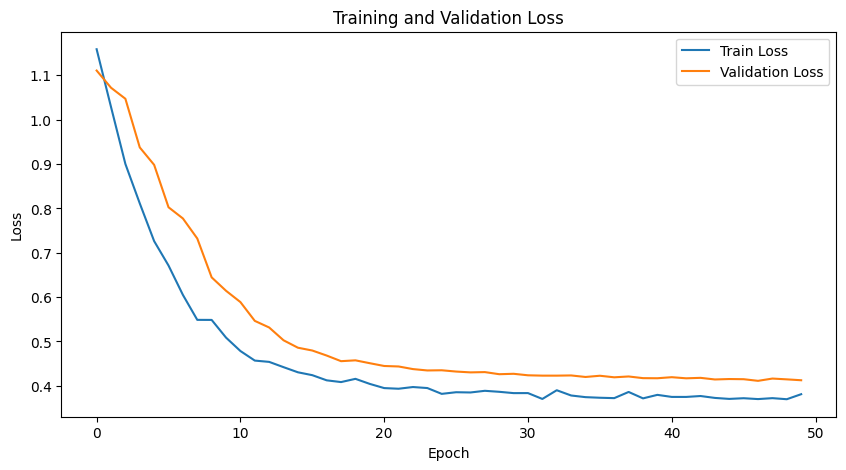

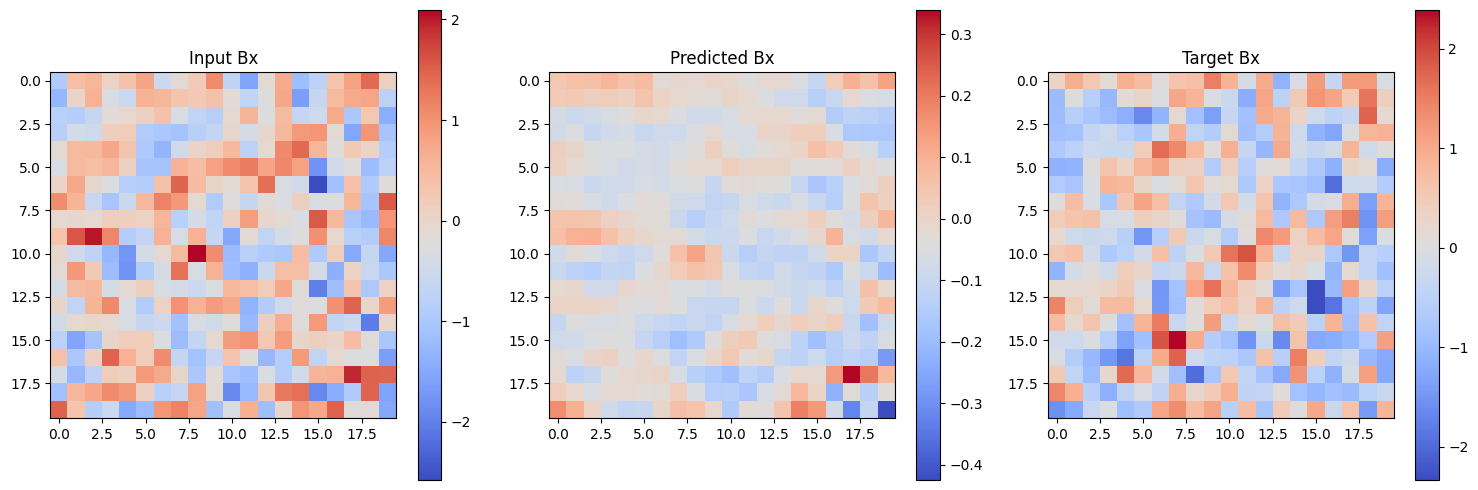

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from astropy.time import Time
import zarr
import s3fs
import sunpy.map
from datetime import datetime

'''processing'''

# AWS 데이터 접근 설정
AWS_ZARR_ROOT = "s3://gov-nasa-hdrl-data1/contrib/fdl-sdoml/fdl-sdoml-v2/sdomlv2_hmi_small.zarr/"

def s3_connection(path_to_zarr):
    return s3fs.S3Map(
        root=path_to_zarr,
        s3=s3fs.S3FileSystem(anon=True),
        check=False,
    )

def load_single_aws_zarr(path_to_zarr, cache_max_single_size=None):
    return zarr.open(
        zarr.LRUStoreCache(
            store=s3_connection(path_to_zarr),
            max_size=cache_max_single_size,
        ),
        mode="r",
    )

class MagneticFieldNormalize:
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, data):
        if not torch.is_tensor(data):
          data = torch.from_numpy(data)
        self.mean = torch.mean(data.float())
        self.std = torch.std(data.float())
        return self

    def __call__(self, x):
        if not torch.is_tensor(x):
          x = torch.from_numpy(x)
        return(x.float()-self.mean)/(self.std+1e-8)

    def inverse_transform(self,x):
        return x*self.std + self.mean

# Neural ODE 모델 정의는 이전과 동일 [이전 코드의 ODEFunc, MagneticFieldPredictor 클래스와 동일]

def prepare_hmi_data(roi_bounds):
    """HMI 데이터 로드 및 전처리"""
    print("Loading HMI data...")

    # Zarr 데이터 로드
    root = load_single_aws_zarr(AWS_ZARR_ROOT)

    roi_bounds = ((160,170), (160,170))
    x_start, x_end = roi_bounds[0]
    y_start, y_end = roi_bounds[1]

    # 자기장 데이터 로드
    data_Bx = root["2010"]["Bx"]
    data_By = root["2010"]["By"]
    data_Bz = root["2010"]["Bz"]

    # 시간 데이터 처리
    t_obs = np.array(data_Bz.attrs["T_OBS"])
    t_obs_new = []
    for string in t_obs:
        new_string = string.replace('_TAI', 'Z')
        new_string = new_string.replace('_', 'T')
        new_string = new_string.replace('.', '-')
        new_string = new_string.replace('Z', '.00')
        t_obs_new.append(new_string)

    t = Time(t_obs_new, format='isot', scale='tai')
    t_obs_new = t.value

    # 시간 DataFrame 생성
    df_time = pd.DataFrame(t_obs_new, index=np.arange(len(t_obs_new)), columns=["Time"])
    df_time["Time"] = pd.to_datetime(df_time["Time"])

    # 12분 간격으로 시간 선택
    selected_times = pd.date_range(
        start="2010-08-28 00:00:00",
        end="2010-08-28 23:59:59",
        freq="3T"
    )

    # 시간 인덱스 찾기
    selected_index = []
    for i in selected_times:
        selected_index.append(np.argmin(abs(df_time["Time"] - i)))

    # 누락된 시간 처리
    missing_index = np.where(abs(df_time['Time'][selected_index] - selected_times) > pd.Timedelta('3m'))[0]
    for i in missing_index:
        selected_index[i] = -1

    # 유효한 시간 인덱스만 필터링
    time_indices = list(filter(lambda x: x > 0, selected_index))
    print(f'befor slicing time indices : {len(time_indices)}')
    print(f'time indices : {time_indices[:]}')

    return data_Bx, data_By, data_Bz, time_indices

def compute_running_stats(data, roi_bounds, chunk_size=30):
    """점진적으로 평균과 표준편차 계산"""
    x_start, x_end = roi_bounds[0]
    y_start, y_end = roi_bounds[1]

    n_chunks = data.shape[0] // chunk_size + (1 if data.shape[0] % chunk_size else 0)

    # Welford's online algorithm 사용
    mean = 0.0
    M2 = 0.0  # 제곱 편차의 합
    count = 0

    print(f"Computing statistics in {n_chunks} chunks...")
    for i in tqdm(range(n_chunks)):
        start_idx = i * chunk_size
        end_idx = min(start_idx + chunk_size, data.shape[0])

        # 청크 데이터 가져오기
        chunk = np.array(data[start_idx:end_idx, x_start:x_end, y_start:y_end])
        chunk_values = chunk.flatten()

        # 통계 업데이트
        for value in chunk_values:
            count += 1
            delta = value - mean
            mean += delta / count
            delta2 = value - mean
            M2 += delta * delta2

    std = np.sqrt(M2 / (count - 1)) if count > 1 else 0
    return mean, std

class MagneticFieldDataset(Dataset):
    def __init__(self, data_Bx, data_By, data_Bz, time_indices, roi_bounds):
        self.data_Bx = data_Bx
        self.data_By = data_By
        self.data_Bz = data_Bz
        self.time_indices = time_indices

        # ROI 범위 정의
        self.x_start, self.x_end = roi_bounds[0]
        self.y_start, self.y_end = roi_bounds[1]

        print("Computing normalization parameters...")
        print("For Bx:")
        self.mean_x, self.std_x = 0.144, 62.450 # compute_running_stats(data_Bx, roi_bounds)
        print("For By:")
        self.mean_y, self.std_y = -0.078, 58.230 # compute_running_stats(data_By, roi_bounds)
        print("For Bz:")
        self.mean_z, self.std_z = 0.167, 31.250 # compute_running_stats(data_Bz, roi_bounds)

        print("Normalization parameters computed.")
        print(f"Bx - mean: {self.mean_x:.3f}, std: {self.std_x:.3f}")
        print(f"By - mean: {self.mean_y:.3f}, std: {self.std_y:.3f}")
        print(f"Bz - mean: {self.mean_z:.3f}, std: {self.std_z:.3f}")

    def normalize(self, x, mean, std):
        return (x - mean) / (std + 1e-8)

    def __len__(self):
        return len(self.time_indices) - 1

    def __getitem__(self, idx):
        start_idx = self.time_indices[idx]
        end_idx = self.time_indices[idx + 1]

        # ROI 슬라이싱
        Bx_t = np.array(self.data_Bx[start_idx, self.x_start:self.x_end, self.y_start:self.y_end])
        By_t = np.array(self.data_By[start_idx, self.x_start:self.x_end, self.y_start:self.y_end])
        Bz_t = np.array(self.data_Bz[start_idx, self.x_start:self.x_end, self.y_start:self.y_end])

        Bx_t1 = np.array(self.data_Bx[end_idx, self.x_start:self.x_end, self.y_start:self.y_end])
        By_t1 = np.array(self.data_By[end_idx, self.x_start:self.x_end, self.y_start:self.y_end])
        Bz_t1 = np.array(self.data_Bz[end_idx, self.x_start:self.x_end, self.y_start:self.y_end])

        # 정규화 적용
        current_state = torch.stack([
            torch.from_numpy(self.normalize(Bx_t, self.mean_x, self.std_x)),
            torch.from_numpy(self.normalize(By_t, self.mean_y, self.std_y)),
            torch.from_numpy(self.normalize(Bz_t, self.mean_z, self.std_z))
        ], dim=0)

        target_state = torch.stack([
            torch.from_numpy(self.normalize(Bx_t1, self.mean_x, self.std_x)),
            torch.from_numpy(self.normalize(By_t1, self.mean_y, self.std_y)),
            torch.from_numpy(self.normalize(Bz_t1, self.mean_z, self.std_z))
        ], dim=0)

        return current_state.float(), target_state.float()

class ConcatConv2d(nn.Module):
    def __init__(self, dim_in, dim_out, ksize = 3, stride = 1, padding = 1):
        super(ConcatConv2d, self).__init__()
        self.conv = nn.Conv2d(dim_in+1, dim_out, ksize, stride, padding)

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :])*t
        ttx = torch.cat([tt, x], 1)
        return self.conv(ttx)

# Neural ODE 모델 정의
class ODEFunc(nn.Module):
    def __init__(self, hidden_dim=32):
        super(ODEFunc, self).__init__()

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout2d(p=0.2)

        self.norm1 = nn.BatchNorm2d(3)
        self.conv1 = ConcatConv2d(3, hidden_dim)

        self.norm2 = nn.BatchNorm2d(hidden_dim)
        self.conv2 = ConcatConv2d(hidden_dim, hidden_dim)

        self.norm3 = nn.BatchNorm2d(hidden_dim)
        self.conv3 = ConcatConv2d(hidden_dim, 3)

        self.norm4 = nn.BatchNorm2d(3)

        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm1(x)
        out = self.conv1(t, out)
        out = self.dropout(out)
        out = self.relu(out)

        out = self.norm2(out)
        out = self.conv2(t, out)
        out = self.dropout(out)
        out = self.relu(out)

        out = self.norm3(out)
        out = self.conv3(t, out)
        out = self.dropout(out)

        out = self.norm4(out)

        return out

class MagneticFieldPredictor(nn.Module):
    def __init__(self, hidden_dim=32):
        super(MagneticFieldPredictor, self).__init__()
        self.ode_func = ODEFunc(hidden_dim)
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.to(x.device)
        out = odeint(
            self.ode_func,
            x,
            self.integration_time,
            method='dopri5',
            rtol=1e-4,
            atol=1e-4)
        return out[1]  # Return the state at t=1

# Loss function
def physics_informed_loss(pred, target, weight_div=0.1):
    # MSE loss
    mse_loss = nn.MSELoss()(pred, target)

    # Divergence loss
    dx = torch.gradient(pred[:, 0], dim=1)[0]
    dy = torch.gradient(pred[:, 0], dim=2)[0]
    dz = torch.gradient(pred[:, 2], dim=1)[0]
    div_loss = torch.mean(torch.abs(dx + dy + dz))

    return mse_loss + weight_div * div_loss

def train(model, train_loader, val_loader, epochs=50, initial_lr=0.001, min_lr = 1e-6, device="cuda"):
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode = 'min',
        factor = 0.5,
        patience=5,
        min_lr = min_lr)

    best_val_loss = float("inf")
    train_losses = []
    val_losses = []

    model = model.to(device)

    final_train_loss = 0
    final_val_loss = 0

    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0.0
        start_nfe = model.ode_func.nfe

        for current_state, target_state in train_loader:
            current_state = current_state.to(device)
            target_state = target_state.to(device)

            optimizer.zero_grad()
            pred = model(current_state)
            loss = physics_informed_loss(pred, target_state)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for current_state, target_state in val_loader:
                current_state = current_state.to(device)
                target_state = target_state.to(device)

                pred = model(current_state)
                loss = physics_informed_loss(pred, target_state)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        epoch_nfe = model.ode_func.nfe - start_nfe

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f} NFE in this epoch : {epoch_nfe}")
        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_magnetic_model.pth")

        final_train_loss = avg_train_loss
        final_val_loss = avg_val_loss

    print(f'\n\n\n Final Training Loss = {final_train_loss} \n Final Val Loss = {final_val_loss} \n total NFE = {model.ode_func.nfe}')

    return train_losses, val_losses

def main():
    # CUDA 사용 가능 여부 확인
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # ROI 설정 (PDF에서 사용된 값)
    roi_bounds = ((160, 180), (160, 180))

    # 데이터 로드
    print("Preparing data...")
    data_Bx, data_By, data_Bz, time_indices = prepare_hmi_data(roi_bounds)
    print(data_Bx[0])

    # 데이터셋 생성
    dataset = MagneticFieldDataset(data_Bx, data_By, data_Bz, time_indices, roi_bounds)

    # Train/Val/Test 분할
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )

    # DataLoader 생성
    hidden_dim=8
    epochs=50
    initial_lr=0.001
    min_lr = 1e-6
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 모델 초기화
    model = MagneticFieldPredictor(hidden_dim=hidden_dim)

    # 학습 실행
    print("Starting training...")
    train_losses, val_losses = train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=epochs,
        initial_lr=initial_lr,
        min_lr = min_lr,
        device=device
    )

    print('=========Training hyperparameter=========',
          f'\n epoch = {epochs}',
          f'\n grid size = {roi_bounds}',
          f'\n hidden dim = {hidden_dim}',
          f'\n batch size = {batch_size}',
          f'\n initial learning rate = {initial_lr}')


    # 학습 결과 시각화
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig('training_history.png')
    plt.show

    # 모델 예측 결과 시각화
    print("Generating prediction visualizations...")
    model.eval()
    with torch.no_grad():
        for i, (input_batch, target_batch) in enumerate(test_loader):
            if i == 0:  # 첫 번째 배치만 시각화
                input_batch = input_batch.to(device)
                pred_batch = model(input_batch)

                # CPU로 이동하여 numpy 배열로 변환
                input_np = input_batch[0].cpu().numpy()
                pred_np = pred_batch[0].cpu().numpy()
                target_np = target_batch[0].numpy()

                # Bz 컴포넌트 시각화
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))

                im0 = axes[0].imshow(input_np[0], cmap='coolwarm')
                axes[0].set_title('Input Bx')
                plt.colorbar(im0, ax=axes[0])

                im1 = axes[1].imshow(pred_np[0], cmap='coolwarm')
                axes[1].set_title('Predicted Bx')
                plt.colorbar(im1, ax=axes[1])

                im2 = axes[2].imshow(target_np[0], cmap='coolwarm')
                axes[2].set_title('Target Bx')
                plt.colorbar(im2, ax=axes[2])

                plt.tight_layout()
                plt.savefig('prediction_visualization.png')
                plt.show
                break

if __name__ == "__main__":
    main()